In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity

import torch
import torch.nn.functional as F

from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
from torch_geometric_temporal.nn.recurrent import A3TGCN2 
from torch_geometric_temporal.nn.attention import ASTGCN   # For information about the architecture check the source code

# GPU support
#DEVICE = torch.device('cuda') # cuda 有GPU記得加上
shuffle=True
batch_size = 8

In [7]:
# 從文件加載數據集的組件
data = torch.load('File/static_graph_temporal_signal.pt')

edge_index = data['edge_index']
edge_attr = data['edge_attr']
features_list = data['features']
targets_list = data['targets']

# 建 StaticGraphTemporalSignal 數據集
dataset = StaticGraphTemporalSignal(
    edge_index=edge_index,
    edge_weight=edge_attr,
    features=features_list,
    targets=targets_list
)

# 打印數據集類型
print("Dataset type: ", type(dataset))

# 計算樣本數量（序列數量）
num_samples = sum(1 for _ in dataset)
print("Number of samples / sequences: ", num_samples)

# 顯示第一個樣本的內容
first_sample = next(iter(dataset))
print("First sample:", first_sample)

/var/folders/dn/6ynt_kvj7q16x61wy32n8bmr0000gn/T/ipykernel_75903/3166564047.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('File/static_graph_temporal

Dataset type:  <class 'torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal'>
Number of samples / sequences:  1940
First sample: Data(x=[5650, 1, 1], edge_index=[2, 47624], edge_attr=[47624], y=[5650, 1])


x=[5650, 1, 1]:

x 是特徵張量，形狀為 [num_nodes, num_features, timesteps]。這裡 num_nodes 是 5650，num_features 是 1，timesteps 是 1。這表示每個節點有一個特徵，且時間步長為 1（這與你的設置不完全一致，可能需要檢查設定）。
edge_index=[2, 47624]:

edge_index 是邊的索引，形狀為 [2, num_edges]，這裡 num_edges 是 47624，表示圖中的邊。
edge_attr=[47624]:

edge_attr 是邊的權重或相似度，形狀為 [num_edges]，這裡 num_edges 是 47624，與 edge_index 的邊數量一致。
y=[5650, 1]:

y 是目標張量，形狀為 [num_nodes, timesteps]，這裡 num_nodes 是 5650，timesteps 是 1。這表示每個節點在這個時間步長上的標籤值。

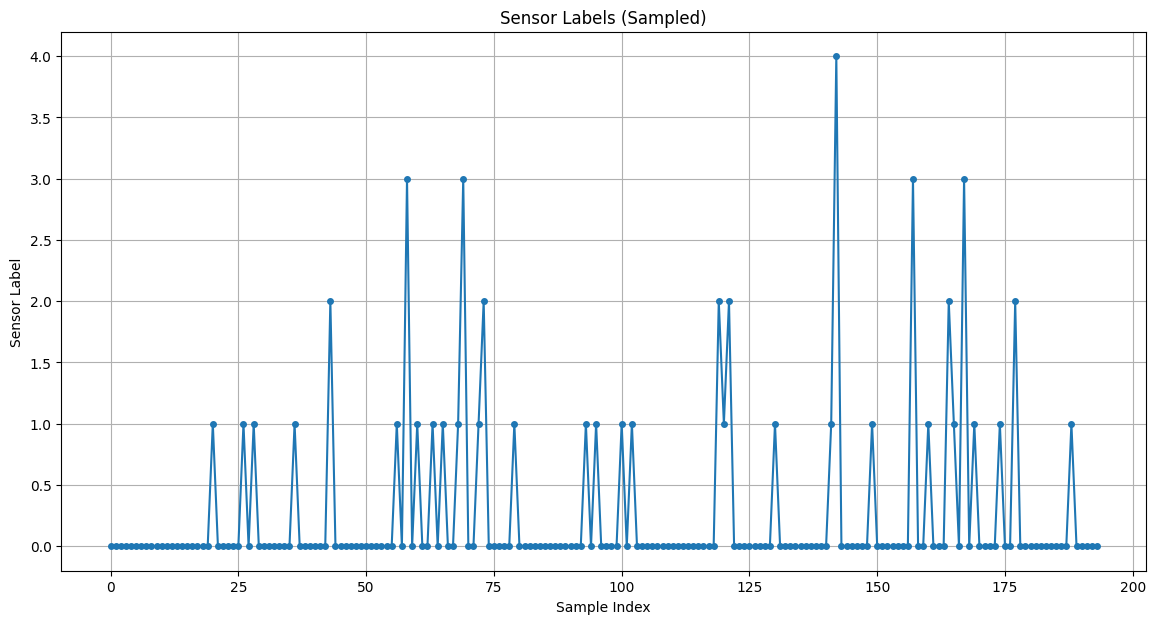

In [8]:
# 每隔 10 個數據點取樣
sensor_number = 1  # 觀察的傳感器
days = 1941  # 觀察365天的數據

# 從 dataset 中提取指定傳感器的真實標籤數據
sensor_labels = [bucket.y[sensor_number][0].item() for bucket in list(dataset)[:days]]
interval = 10
sensor_labels_sampled = sensor_labels[::interval]

# 繪製取樣後的數據
plt.figure(figsize=(14, 7))
plt.plot(sensor_labels_sampled, marker='o', linestyle='-', markersize=4)
plt.title("Sensor Labels (Sampled)")
plt.xlabel("Sample Index")
plt.ylabel("Sensor Label")
plt.grid(True)
plt.show()

In [9]:
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

train_count = sum(1 for _ in train_dataset)
test_count = sum(1 for _ in test_dataset)

print("Number of train buckets: ", train_count)
print("Number of test buckets: ", test_count)

Number of train buckets:  1552
Number of test buckets:  388


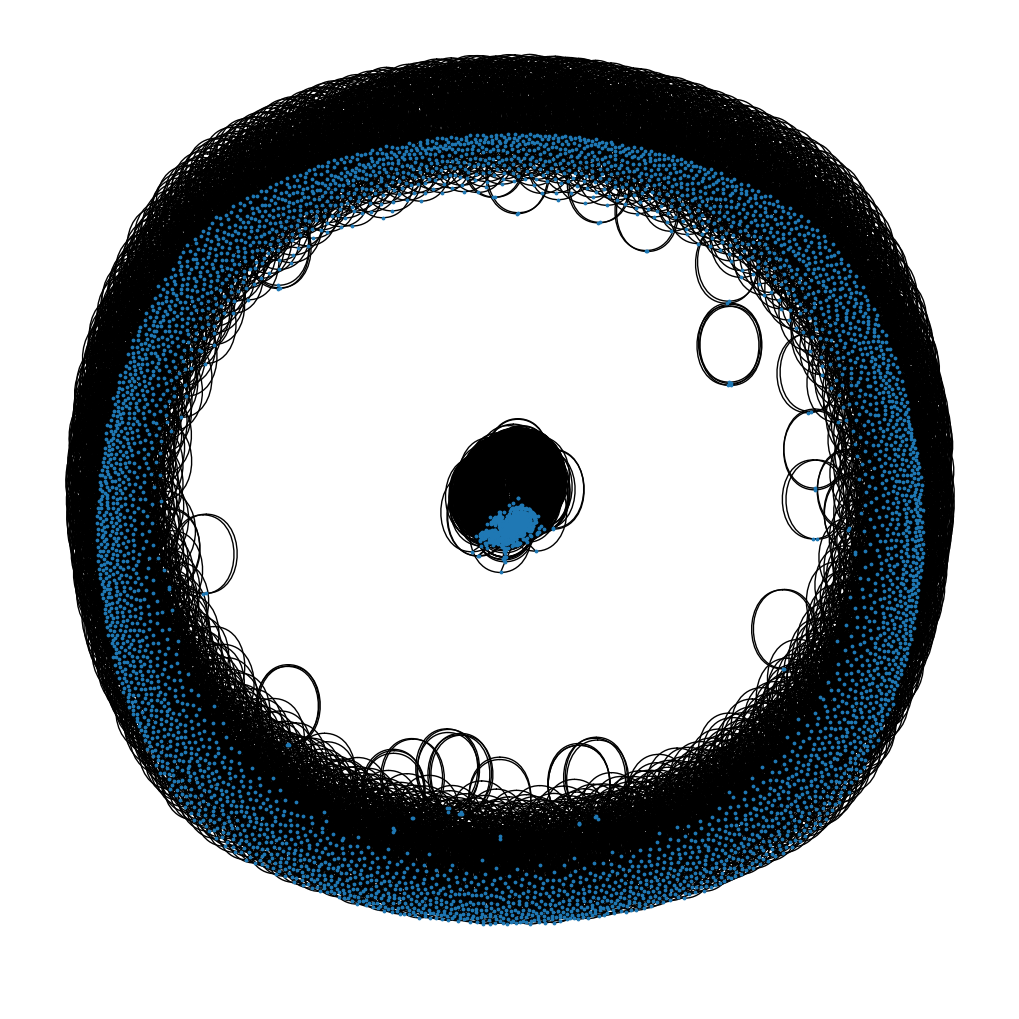

In [58]:
if non_zero_elements > 0:
    # 繪製圖形
    rows, cols = np.where(adj_matrix > 0)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)

    plt.figure(figsize=(10, 10))  # 調整繪圖大小
    nx.draw(gr, node_size=3)
    plt.show()
else:
    print("The adjacency matrix contains no edges, and therefore no graph can be drawn.")

# ***Creating DataLoaders***

In [10]:
train_input = np.array(train_dataset.features) # e.g (27399, 207, 2, 12) / (1552, 5650, 1, 1)
train_target = np.array(train_dataset.targets) # e.g (27399, 207, 12) / (1552, 5650, 1)
train_x_tensor = torch.from_numpy(train_input).type(torch.FloatTensor).to()  # (B, N, F, T)
train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to()  # (B, N, T)
train_dataset_new = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

print(train_input.shape)
print(train_target.shape)
print(train_x_tensor.shape)
print(train_target_tensor.shape)
print(train_dataset_new)
print(train_loader)

(1552, 5650, 1, 1)
(1552, 5650, 1)
torch.Size([1552, 5650, 1, 1])
torch.Size([1552, 5650, 1])


In [11]:
test_input = np.array(test_dataset.features) # (, 207, 2, 12)
test_target = np.array(test_dataset.targets) # (, 207, 12)
test_x_tensor = torch.from_numpy(test_input).type(torch.FloatTensor).to()  # (B, N, F, T)
test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to()  # (B, N, T)
test_dataset_new = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

print(test_input.shape)
print(test_target.shape)
print(test_x_tensor.shape)
print(test_target_tensor.shape)
print(test_dataset_new)
print(test_loader)

(388, 5650, 1, 1)
(388, 5650, 1)
torch.Size([388, 5650, 1, 1])
torch.Size([388, 5650, 1])


# ***Model***

In [12]:
class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods, batch_size):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN2(in_channels=node_features,  out_channels=32, periods=periods,batch_size=batch_size) # node_features=2, periods=12
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index) # x [b, 207, 2, 12]  returns h [b, 207, 12]
        h = F.relu(h)
        h = self.linear(h)
        return h

In [13]:
# Create model and optimizers
model = TemporalGNN(node_features=1, periods=1, batch_size=batch_size).to()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()


# print('Net\'s state_dict:')
# total_param = 0
# for param_tensor in model.state_dict():
#     print(param_tensor, '\t', model.state_dict()[param_tensor].size())
#     total_param += np.prod(model.state_dict()[param_tensor].size())
# print('Net\'s total params:', total_param)
# #--------------------------------------------------
# print('Optimizer\'s state_dict:')
# for var_name in optimizer.state_dict():
#     print(var_name, '\t', optimizer.state_dict()[var_name])

Net's state_dict:
tgnn._attention 	 torch.Size([1])
tgnn._base_tgcn.conv_z.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_z.lin.weight 	 torch.Size([32, 1])
tgnn._base_tgcn.linear_z.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_z.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_r.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_r.lin.weight 	 torch.Size([32, 1])
tgnn._base_tgcn.linear_r.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_r.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_h.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_h.lin.weight 	 torch.Size([32, 1])
tgnn._base_tgcn.linear_h.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_h.bias 	 torch.Size([32])
linear.weight 	 torch.Size([1, 32])
linear.bias 	 torch.Size([1])
Net's total params: 6466
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 

# ***Graph loading***

In [20]:
for snapshot in train_dataset:
    static_edge_index = snapshot.edge_index.to()
    break;

 Current Epoch 1
LOSS: [4.354310989379883, 4.359709739685059, 4.559652805328369, 4.933681488037109] / LOSS AVG: 4.5518
LOSS: [4.354310989379883, 4.359709739685059, 4.559652805328369, 4.933681488037109, 4.6010541915893555, 4.031226634979248, 4.06367301940918, 3.726339817047119] / LOSS AVG: 4.3287
LOSS: [4.354310989379883, 4.359709739685059, 4.559652805328369, 4.933681488037109, 4.6010541915893555, 4.031226634979248, 4.06367301940918, 3.726339817047119, 3.7222068309783936, 3.1160366535186768, 5.636383533477783, 3.801903009414673] / LOSS AVG: 4.2422
LOSS: [4.354310989379883, 4.359709739685059, 4.559652805328369, 4.933681488037109, 4.6010541915893555, 4.031226634979248, 4.06367301940918, 3.726339817047119, 3.7222068309783936, 3.1160366535186768, 5.636383533477783, 3.801903009414673, 3.653022289276123, 3.7216310501098633, 4.22037935256958, 5.384110927581787] / LOSS AVG: 4.2428
LOSS: [4.354310989379883, 4.359709739685059, 4.559652805328369, 4.933681488037109, 4.6010541915893555, 4.0312266349

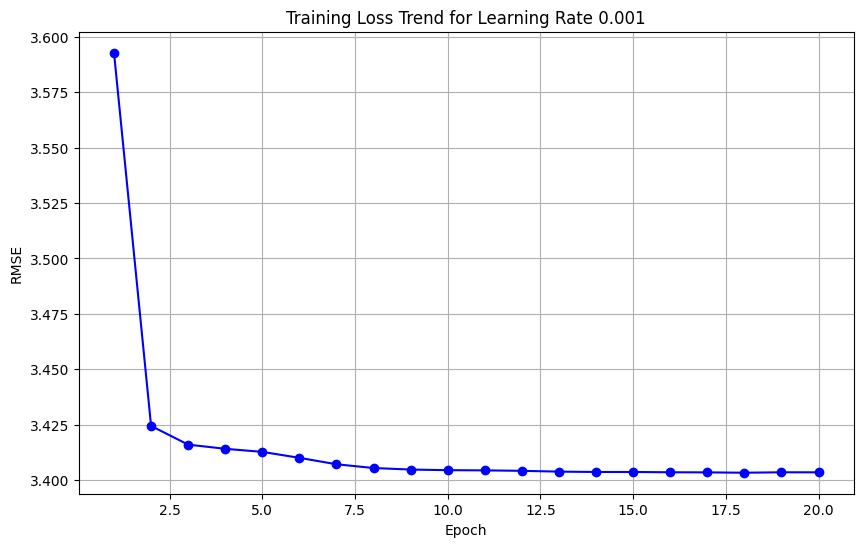

 Current Epoch 1
LOSS: [3.598613739013672, 4.513560771942139, 4.464138984680176, 3.2864573001861572] / LOSS AVG: 3.9657
LOSS: [3.598613739013672, 4.513560771942139, 4.464138984680176, 3.2864573001861572, 3.4817848205566406, 3.9823873043060303, 3.3379781246185303, 4.4192118644714355] / LOSS AVG: 3.8855
LOSS: [3.598613739013672, 4.513560771942139, 4.464138984680176, 3.2864573001861572, 3.4817848205566406, 3.9823873043060303, 3.3379781246185303, 4.4192118644714355, 3.710700750350952, 3.976048231124878, 5.014053821563721, 4.207517147064209] / LOSS AVG: 3.9994
LOSS: [3.598613739013672, 4.513560771942139, 4.464138984680176, 3.2864573001861572, 3.4817848205566406, 3.9823873043060303, 3.3379781246185303, 4.4192118644714355, 3.710700750350952, 3.976048231124878, 5.014053821563721, 4.207517147064209, 4.533360481262207, 5.471774578094482, 3.7900021076202393, 4.718498229980469] / LOSS AVG: 4.1566
LOSS: [3.598613739013672, 4.513560771942139, 4.464138984680176, 3.2864573001861572, 3.4817848205566406

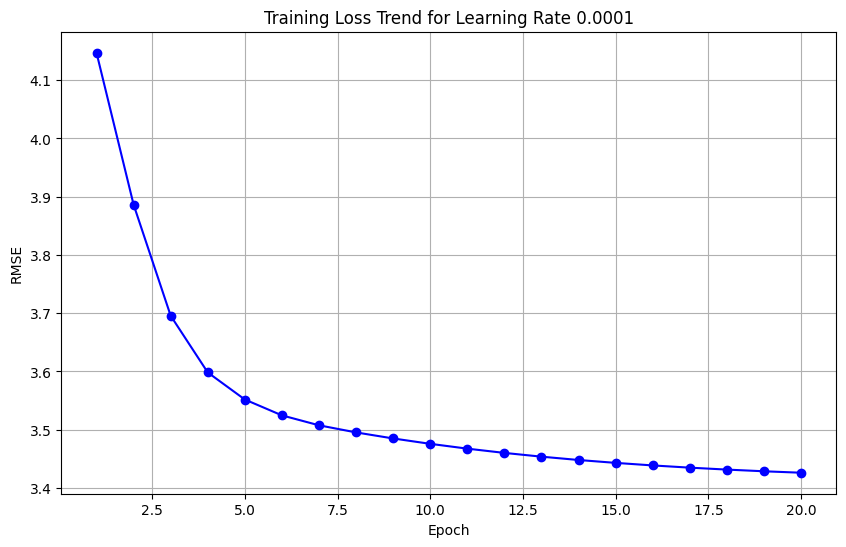

 Current Epoch 1
LOSS: [4.387655735015869, 4.105662822723389, 4.0938496589660645, 5.0907063484191895] / LOSS AVG: 4.4195
LOSS: [4.387655735015869, 4.105662822723389, 4.0938496589660645, 5.0907063484191895, 3.8720078468322754, 3.98201060295105, 3.5422956943511963, 5.53090763092041] / LOSS AVG: 4.3256
LOSS: [4.387655735015869, 4.105662822723389, 4.0938496589660645, 5.0907063484191895, 3.8720078468322754, 3.98201060295105, 3.5422956943511963, 5.53090763092041, 4.947943687438965, 4.207420349121094, 3.369483232498169, 3.858449935913086] / LOSS AVG: 4.2490
LOSS: [4.387655735015869, 4.105662822723389, 4.0938496589660645, 5.0907063484191895, 3.8720078468322754, 3.98201060295105, 3.5422956943511963, 5.53090763092041, 4.947943687438965, 4.207420349121094, 3.369483232498169, 3.858449935913086, 4.306888103485107, 3.5688772201538086, 4.874298095703125, 4.317357540130615] / LOSS AVG: 4.2535
LOSS: [4.387655735015869, 4.105662822723389, 4.0938496589660645, 5.0907063484191895, 3.8720078468322754, 3.982

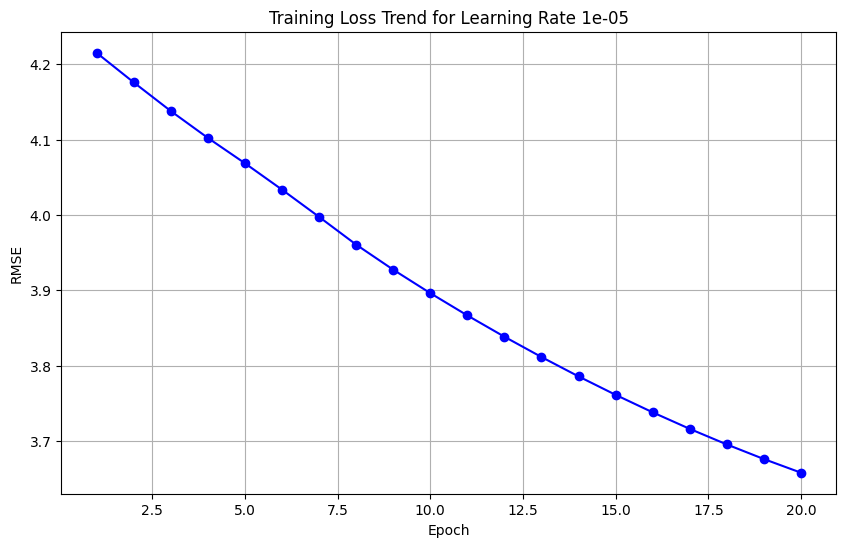

In [25]:
hyturingForLearingRate = [0.001, 0.0001, 0.00001]

for learning_rate in hyturingForLearingRate:
    model = TemporalGNN(node_features=1, periods=1, batch_size=batch_size).to()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = torch.nn.MSELoss()

    for snapshot in train_dataset:
        static_edge_index = snapshot.edge_index.to()
        break

    # 訓練設置
    num_epochs = 20  # 訓練的總 epoch 數
    epoch_losses = []  # 用來存儲每個 epoch 的平均損失
    
    # 模型訓練過程
    model.train()
    
    for epoch in range(num_epochs):
        print(f" Current Epoch {epoch + 1}")
        step = 0
        loss_list = []  # 每個 epoch 開始時初始化損失列表
    
        for encoder_inputs, labels in train_loader:
            y_hat = model(encoder_inputs, static_edge_index)  # 模型預測
            loss = loss_fn(y_hat, labels)  # 計算均方誤差 (MSE) 損失
            loss.backward()  # 反向傳播
            optimizer.step()  # 更新模型參數
            optimizer.zero_grad()  # 清零梯度
            step += 1
            loss_list.append(loss.item())  # 記錄當前批次的損失
    
            # 每4個批次打印一次當前損失和平均損失
            if step % 4 == 0:
                print("LOSS: {} / LOSS AVG: {:.4f}".format(loss_list, sum(loss_list)/len(loss_list)))
    
        # 計算並存儲當前 epoch 的平均損失
        epoch_loss = sum(loss_list) / len(loss_list)
        epoch_losses.append(epoch_loss)
        print(f"Epoch {epoch + 1} RMSE: {epoch_loss:.4f}")
    
    # 繪製損失隨 epochs 的收斂圖
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', linestyle='-', color='b')
    plt.title(f'Training Loss Trend for Learning Rate {learning_rate}')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.grid(True)
    plt.show()

# ***Evaluate***

In [38]:
#learning rate = 0.001 #跑太慢，所以我先用之前的learning rate = 0.001跑了一個
model.eval()
step = 0
# Store for analysis
total_loss = []
for encoder_inputs, labels in test_loader:
    # Get model predictions
    y_hat = model(encoder_inputs, static_edge_index)
    # Mean squared error
    loss = loss_fn(y_hat, labels)
    total_loss.append(loss.item())
    # Store for analysis below
    #test_labels.append(labels)
    #predictions.append(y_hat)

print("Test MSE: {:.4f}".format(sum(total_loss)/len(total_loss)))

Test MSE: 4.1212


# ***Visualisation***

In [43]:
sensor = 123
timestep = 0 #根據時間改動 #時間步減1
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in y_hat])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)    

Data points:, (32,)


<Axes: >

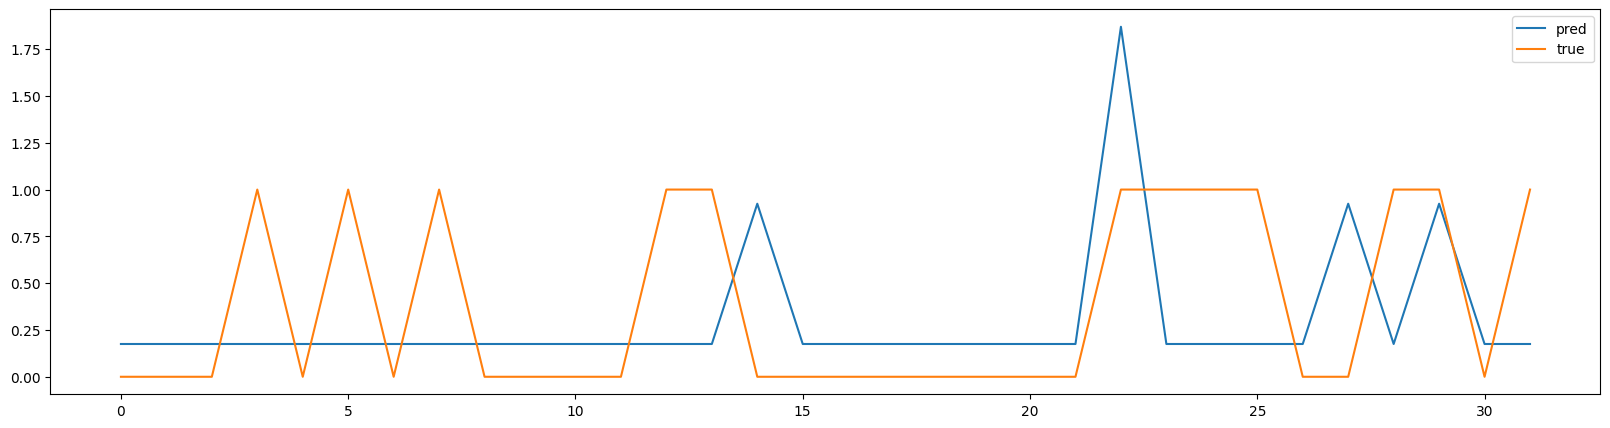

In [44]:
plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true")